# cnr-03-roi-cm-and-radii

A.L. 20211027

Find center of mass (CM) and equidistant radii (voxel arrays) originating from CM in 3D

Unzipped `Marion.zip` from M.L.B 20211006  --> CC1, CC2, CC3; 

CC1 -> 5_t2_tse_HiRes_skra_tra_3mm ,  5_t2_tse_HiRes_skra_tra_3mm_TumorMask_KWL


In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import shutil
import subprocess as subp
import pathlib
import glob
import shutil
from datetime import date
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel.viewers import OrthoSlicer3D
import scipy
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from nilearn.image.image import mean_img
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython
from scipy import ndimage as ndi

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
MacOS = True


home = os.path.expanduser('~')            # To make path to local home directory
#datastore = f'{home}/Dropbox/Arvid/MMIV.no/Marion_Berge_PhD_HVL'   # '/media/arvid/sata12tb'
datastore = '../data' 

if MacOS:
    TREE = '/usr/local/bin/tree'          # MacOS (brew install tree)
    MRICONVERT = '/Applications/freesurfer/7.2.0/bin/mri_convert'
    DCMCONVERT = f'{home}/opt/anaconda3/envs/tumor-cnr/bin/dcm2niix'
    
else:
    TREE = '/usr/bin/tree'
    MRICONVERT = '/usr/local/freesurfer/bin/mri_convert'
    DCMCONVERT = f'{home}/anaconda3/envs/tumor-cnr/bin/dcm2niix'

FSLREORIENT2STD = '/usr/local/fsl/bin/fslreorient2std'
FLIRT = '/usr/local/fsl/bin/flirt'
FSLMATHS = '/usr/local/fsl/bin/fslmaths'


dicoms = f'{datastore}/dicom'         
nifti_dcm2niix = f'{datastore}/nifti_dcm2niix' # Converted DICOMS using dcm2niix in Python


#template = 'T1w'


# AD HOC colormap for HD-GLIO  (CE, NE)-segmentation overlay
colors = [(1, 0, 0), (0, 0, 1), (0, 1, 0)]  # R -> B -> G
n_bins = [2, 3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_cm'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[0])

## Read converted NIFTI files

In [5]:
subjs = [
    'CC1', 'CC2', 'CC3'
]
subjs

['CC1', 'CC2', 'CC3']

In [89]:
cwd = os.getcwd()
res_dir = f'{cwd}/../data/results'

### Inspect T2w and ROIs

In [90]:
#sub = 'CC1'
#x, y, z = -20, -9, -38    # RAS coordinates
#chns = ['t2', 't2_roi']

In [91]:
#%%time
#for i, chn in enumerate(chns):
#    fn_inp = f'{res_dir}/{sub}_{chn}.nii.gz'
#    img = nib.load(fn_inp)
#    # OrthoSlicer3D(img.get_fdata(), affine= img.affine, title=template).show()
#    fig, ax  = plt.subplots(1, 1, figsize=(15,6))
#    title = f'{chn}: {img.shape}, {img.header.get_zooms()}'
#    plotting.plot_anat(img, axes = ax, title=title, cmap='gray', dim= -0.7, cut_coords = (x, y, z))
#    plt.show()

## Display channel image and the ROI

In [166]:
def display_channels_and_roi(T2, roi, BG_IMG):
    channels = [T2]
    img = nib.load(roi)
    data = img.get_fdata()
    values, counts = np.unique(data.astype(int), return_counts=True)
    unique = dict(zip(values,counts))
    coll = list(unique.items())
    unique = dict(coll[1:])
    for i, chn in enumerate(channels):
        if BG_IMG == 'T2' and i==0:
            fig, ax  = plt.subplots(1, 1, figsize=(15,6))
            plotting.plot_roi(roi, axes=ax, title=f'{os.path.split(roi)[1]} ({unique}) on T2', \
                              bg_img=channels[i], alpha=0.8, dim=-0.7, cmap='Blues_r') #cmap='Paired')

In [94]:
#T2 = f'{res_dir}/{sub}_t2.nii.gz'
#file_roi = f'{res_dir}/{sub}_t2_roi.nii.gz'

#channels = ['T2']
#for BG_IMG in channels:
#    display_channels_and_roi(T2, file_roi, BG_IMG)

## CM of 3D ROI

- Wikipedia Center of mass - https://en.wikipedia.org/wiki/Center_of_mass
- scipy.ndimage.measurements.center_of_mass



In [95]:
masses = np.array(
# x   y   z   value    
[
[0,  0,  0,  0],
[0,  1,  0,  0],
[0,  2,  0,  0],
[1,  0,  0,  0],
[1,  1,  0,  1],
[1,  2,  0,  1],
[2,  0,  0,  0],
[2,  1,  0,  0],
[2,  2,  0,  0]
])


In [121]:
CMtest = np.average(masses[:,:3], axis=0, weights=masses[:,3])
CMtest

array([1. , 1.5, 0. ])

In [190]:
subj = 'CC2'

In [191]:
file_ROI = f'{res_dir}/{subj}_t2_roi.nii.gz'
roi = nib.load(file_ROI)
mask3d = roi.get_fdata()
roi_header = roi.header
roi_affine = roi.affine

In [192]:
file_img = f'{res_dir}/{subj}_t2.nii.gz'
img = nib.load(file_img)
data3d = img.get_fdata()
img_header = img.header
img_affine = img.affine

In [193]:
mask3d.shape

(384, 384, 28)

In [194]:
data3d.shape

(384, 384, 28)

In [195]:
#mask3d[156,174,15]

In [196]:
non0 = np.argwhere(mask3d > 0)

In [197]:
list(np.average(non0[:,:], axis=0, returned=False).round(0).astype(np.uint8))

[216, 193, 13]

In [198]:
list(np.average(non0[:,:], axis=0, returned=True))

[array([215.78042763, 192.81085526,  12.64638158]),
 array([1216., 1216., 1216.])]

In [199]:
data3d[ non0[:,0], non0[:,1], non0[:,2] ].sum()

493377.0

In [200]:
list(np.average(non0[:,:], axis=0, weights=data3d[ non0[:,0], non0[:,1], non0[:,2] ]).round(0).astype(np.uint8))

[216, 193, 13]

In [201]:
list(np.average(non0[:,:], axis=0, weights=data3d[ non0[:,0], non0[:,1], non0[:,2] ], returned=True))

[array([215.57808532, 192.82894622,  12.68305778]),
 array([493377., 493377., 493377.])]

In [202]:
CM_bin = list(np.average(non0[:,:], axis=0, returned=False).round(0).astype(np.uint8))
CM_bin

[216, 193, 13]

In [203]:
mask3d.dtype

dtype('float64')

In [204]:
mask3d[CM_bin[0],CM_bin[1],CM_bin[2]]

1.0

### Scanner (x,y,z)  vs. Image (i,j,k)  and homogeneous coordinates

RAS = Right-Anterior-Superior

Th image volume in real space (scanner coordinate system, laboratory frame) are encoded in the x, y, and z vectors. These vectors describe the mapping from a logical coordinate system to a physical RAS (Right-Anterior-Superior) sense. The x vector describes how the "PhaseEncode" logical dimension is mapped to RAS coordinates; the y vector describes how the "ReadOut" logical dimension is mapped; and the z vector describes how the "SliceSelect" logical dimension is mapped.

The RAS (Right-Anterior-Superior) sense is patient-relative, and specifies the following orthogonal base
axes originating in the center of k-space, i.e. the center of the scanned volume: (1) from the origin to the
patient's right: (2) from the origin to the patient's front; and (3) from the origin towards the top of the
patient's head. These directions are normal to the following planes respectively: (1) sagittal; (2) coronal;
(3) transverse.

- https://en.wikipedia.org/wiki/Homogeneous_coordinates
- https://nipy.org/nibabel/coordinate_systems.html
- https://surfer.nmr.mgh.harvard.edu/fswiki/CoordinateSystems
- https://surfer.nmr.mgh.harvard.edu/fswiki/CoordinateSystems?action=AttachFile&do=get&target=fscoordinates.pdf
- https://surfer.nmr.mgh.harvard.edu/fswiki/CoordinateSystems?action=AttachFile&do=get&target=vox2ras.pdf

FreeSurfer:  **(Ex: CC1)**
```
RAS -20.95, -6.84, -38.56
TkReg RAS (CC1_t2_roi_cm.nii) 2.25, 7.50, -7.87
CC1_t2_roi_cm.nii.gz  255 	[156, 174, 15]
```

In [205]:
def get_vox2ras_tkr(t1):
    '''Get the vox2ras-tkr transform. Inspired
    by get_vox2ras_tkr in
    https://neurostars.org/t/get-voxel-to-ras-transformation-from-nifti-file/4549/4
    '''
    ds = t1.header.get_zooms()[:3]
    ns = np.array(t1.shape[:3]) * ds / 2.0
    v2rtkr = np.array([[-ds[0], 0, 0, ns[0]],
                       [0, 0, ds[2], -ns[2]],
                       [0, -ds[1], 0, ns[1]],
                       [0, 0, 0, 1]], dtype=np.float32)
    return v2rtkr

In [206]:
get_vox2ras_tkr(roi)

array([[ -0.5208333,   0.       ,   0.       , 100.       ],
       [  0.       ,   0.       ,   3.3      , -46.2      ],
       [  0.       ,  -0.5208333,   0.       , 100.       ],
       [  0.       ,   0.       ,   0.       ,   1.       ]],
      dtype=float32)

In [207]:
np.array(CM_bin + [1])

array([216, 193,  13,   1])

In [208]:
def vox2ras(A, v):
    return np.dot(A,v)

A = get_vox2ras_tkr(roi)
v = np.array(CM_bin + [1])

vox2ras(A, v)

array([-12.49999571,  -3.30000138,  -0.5208295 ,   1.        ])

**Applying the affine** (https://nipy.org/nibabel/coordinate_systems.html) <br>
To make the affine simpler to apply, we split it into M and (a,b,c):

```
M = roi.affine[:3, :3]
abc = roi.affine[:3, 3]
```

In [209]:
def vox2ras(nifti, ijk):
    """ 
    Applying the affine (https://nipy.org/nibabel/coordinate_systems.html)
    To make the affine simpler to apply, we split it into M and (a,b,c)
    Return X, Y, Z coordinates for voxel location ijk with coordinates [i, j, k] 
    """
    M = nifti.affine[:3, :3]
    abc = nifti.affine[:3, 3]
    
    return list(M.dot([ijk[0], ijk[1], ijk[2]]) + abc)

In [210]:
vox2ras(roi, CM_bin)

[-30.28006749294495, -31.09941080957651, 21.448292888700962]

In [212]:
x, y, z = vox2ras(roi, CM_bin)[0], vox2ras(roi, CM_bin)[1], vox2ras(roi, CM_bin)[2] # -20.95, -6.84, -38.56 # RAS coordinates
chns = ['t2', 't2_roi']

x

-30.28006749294495

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


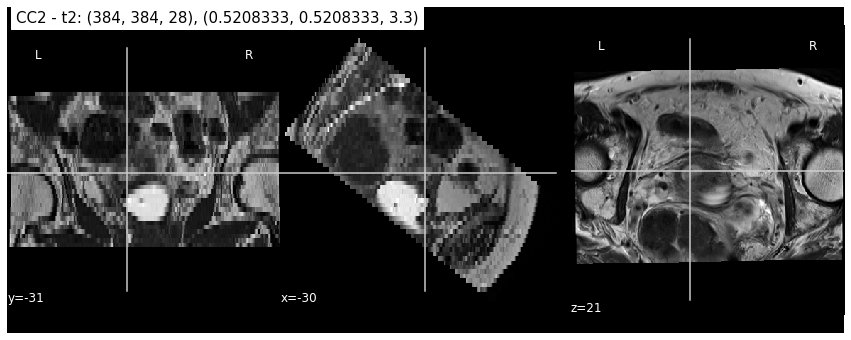

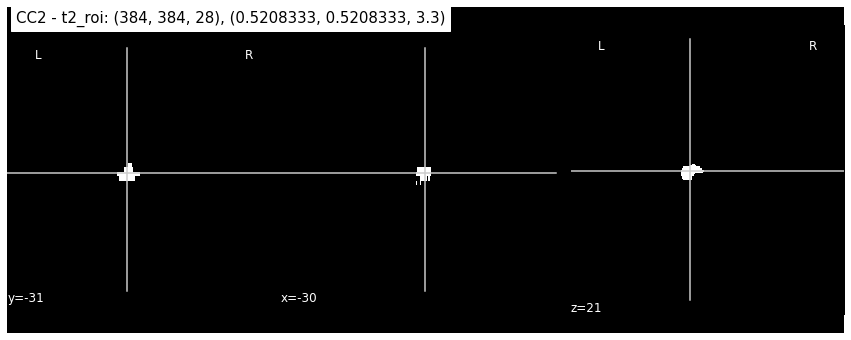

CPU times: user 5.92 s, sys: 162 ms, total: 6.08 s
Wall time: 3.74 s


In [213]:
%%time
for i, chn in enumerate(chns):
    fn_inp = f'{res_dir}/{subj}_{chn}.nii.gz'
    img = nib.load(fn_inp)
    # OrthoSlicer3D(img.get_fdata(), affine= img.affine, title=template).show()
    fig, ax  = plt.subplots(1, 1, figsize=(15,6))
    title = f'{subj} - {chn}: {img.shape}, {img.header.get_zooms()}'
    plotting.plot_anat(img, axes = ax, title=title, cmap='gray', dim= -0.7, cut_coords = (x, y, z))
    plt.show()

In [84]:
#intv = list(np.linspace(-1,1,num=3).astype(np.int8))
#intv

In [214]:
T2 = f'{res_dir}/{subj}_t2.nii.gz'
file_roi_cm = f'{res_dir}/{subj}_t2_roi_cm.nii.gz'

mask3d_cm = np.zeros(mask3d.shape, dtype=np.uint8)

mask3d_cm[CM_bin[0],CM_bin[1],CM_bin[2]] = 255

mask3d_cm_nifti = nib.nifti1.Nifti1Image(mask3d_cm.astype(np.uint8),   # .astype(np.bool_),
                                            affine=roi_affine,
                                            header=roi_header)
nib.save(mask3d_cm_nifti, file_roi_cm)

/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/nilearn/image/resampling.py:531: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/Users/arvid/opt/anaconda3/envs/tumor-cnr/lib/python3.8/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


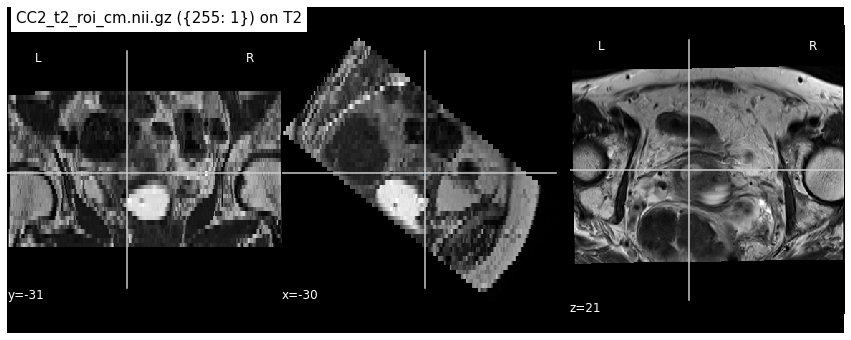

In [215]:
channels = ['T2']
for BG_IMG in channels:
    #display_channels_and_roi(T2, file_roi_cm, BG_IMG)
    display_channels_and_roi(T2, file_roi_cm, BG_IMG)

# AD HOC visualization in Freesurfer's `freeview`

In [216]:
# cm_x = f'{CM_bin[0]}'

cm_x = x
cm_y = y
cm_z = z

In [217]:
%%bash -s "$subj" "$home" "$cm_x" "$cm_y" "$cm_z"

echo "subject: $1"


FREESURFER_HOME=/Applications/freesurfer/7.2.0; export FREESURFER_HOME   # MacOS
#FREESURFER_HOME=/usr/local/freesurfer; export FREESURFER_HOME
PATH=${FREESURFER_HOME}/bin:${PATH}; export PATH
SUBJECTS_DIR=$2/GitHub/tumor-cnr/data/results; export SUBJECTS_DIR
FSLDIR=/usr/local/fsl; export FSLDIR
PATH=${FSLDIR}/bin:${PATH}; export PATH
. ${FSLDIR}/etc/fslconf/fsl.sh
source ${FREESURFER_HOME}/SetUpFreeSurfer.sh

cd $SUBJECTS_DIR

freeview -v \
$1_t2.nii.gz \
$1_t2_roi.nii.gz:colormap=heat:opacity=0.6 \
$1_t2_roi_cm.nii.gz:colormap=heat:opacity=0.1 \
$1_t2_roi_dilated_ball3.nii.gz:colormap=heat:opacity=0.4 \
-ras $3 $4 $5



subject: CC2
INFO: this is an unsiged short. I'll try to read it, but
      it might not work if there are values over 32k
      it might not work if there are values over 32k
but
INFO: this is an unsiged short. I'll try to read it, but
      it might not work if there are values over 32k
      it might not work if there are values over 32k
but
INFO: this is an unsiged short. I'll try to read it, but
      it might not work if there are values over 32k
      it might not work if there are values over 32k
but


In [ ]:
from IPython.display import Image
#Image(filename='./assets/hd-glio_003_1.png', width=900)